In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
# #list of column names and types used only as reference to see what columns we have in database
# columns = inspector.get_columns('measurement')
# for c in columns:
#     print(c['name'],c["type"])


columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement

In [10]:
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# last_date=last_date[0]
last_date

('2017-08-23',)

In [13]:
conn = engine.connect()

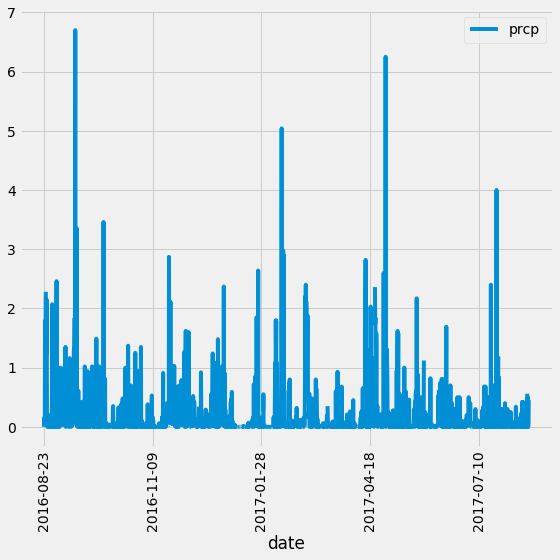

In [25]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# last_year = dt.datetime.strptime(last_date[0],"%Y-%m-%d") - dt.timedelta(days=365)
last_year = dt.date(2017,8,23) - dt.timedelta(days=365)
last_year
# Perform a query to retrieve the data and precipitation scores
sel=[Measurement.date,
#      Measurement.station, used just for reference. Visualized queried info
     Measurement.prcp
    ]
precipitation = session.query(*sel).filter(Measurement.date>=last_year).order_by(Measurement.date).all()

precipitation
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation,columns=['date','prcp'])
df.set_index('date',inplace=True)
# Sort the dataframe by date
df.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90,figsize=(8,8))
plt.tight_layout()
plt.show()



In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(func.count(Station.station)).all()
stations

[(9,)]

In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel=[Measurement.station,
     func.count(Measurement.station)
    ]
popular_station = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).limit(5).all()
popular_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel1 = [Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
       ]
popular_temperature=session.query(*sel1).filter(Measurement.station==popular_station[0][0]).all()
popular_temperature

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

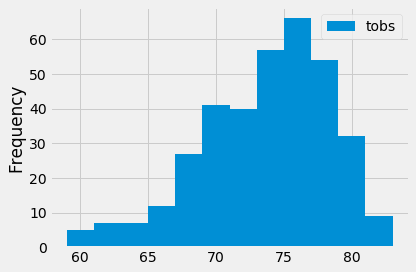

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(Measurement.date).filter(Measurement.station==popular_station[0][0]).order_by(Measurement.date.desc()).first()
last_date
# Calculate the date one year from the last date in data set.
last_year = dt.date(2017,8,18) - dt.timedelta(days=365)
last_year
# # Perform a query to retrieve the data and precipitation scores
sel2=[Measurement.date,
#       Measurement.station,
     func.sum(Measurement.tobs),
    ]
popular_temperatures = session.query(*sel2).\
    filter(Measurement.date>=last_year).\
    filter(Measurement.station==popular_station[0][0]).\
    group_by(Measurement.date).\
    order_by(Measurement.date.desc()).all()
popular_temperatures
 # Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(popular_temperatures,columns=['date','tobs'])
df
df.set_index('date',inplace=True)
 # Sort the dataframe by date
df.sort_values(by=['date'])
# Use Pandas Plotting with Matplotlib to plot the data

df.plot.hist(bins=12)
plt.tight_layout()
plt.show()

# Close session

In [31]:
# Close Session
session.close()